# Variational Autoencoder for Data Generation (Realistic Data Generation)

## Import Libraries

In [ ]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

from tqdm import tqdm

import torch.distributions as D

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation

from scipy.stats import multivariate_normal

## Set Random Seed

In [ ]:
def reset_seeds(seed=42):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  np.random.seed(seed)

# Variational Auto Encoder
We will be implementing a Variational AutoEncoder. We will start by creating data points from a Gaussina misture model.

In [ ]:
reset_seeds()

# Parameters for the GMM components
n_data = 500  # Total number of data points
n_gaussians = 10  # Number of GMM mixture components

# Generate parameters for GMM components
means = torch.rand(n_gaussians, 2) * 10 - 5  # Uniformly distributed in [-5, 5]
stds = torch.rand(n_gaussians, 2) * 1 + 0.5  # Uniformly distributed in [0.5, 1.5]

mixture_weights = torch.ones(n_gaussians) / n_gaussians  # Equal weights for simplicity
mixture_distribution = torch.distributions.Categorical(mixture_weights)
component_distribution = torch.distributions.Independent(torch.distributions.Normal(means, stds), 1)
gmm = torch.distributions.MixtureSameFamily(mixture_distribution, component_distribution)

# Sample data from the GMM
X = gmm.sample((n_data,))

In [ ]:
X_max = X.max(dim=0)[0]
X_min = X.min(dim=0)[0]

X = (X - X_min) / (X_max - X_min) * 2 - 1

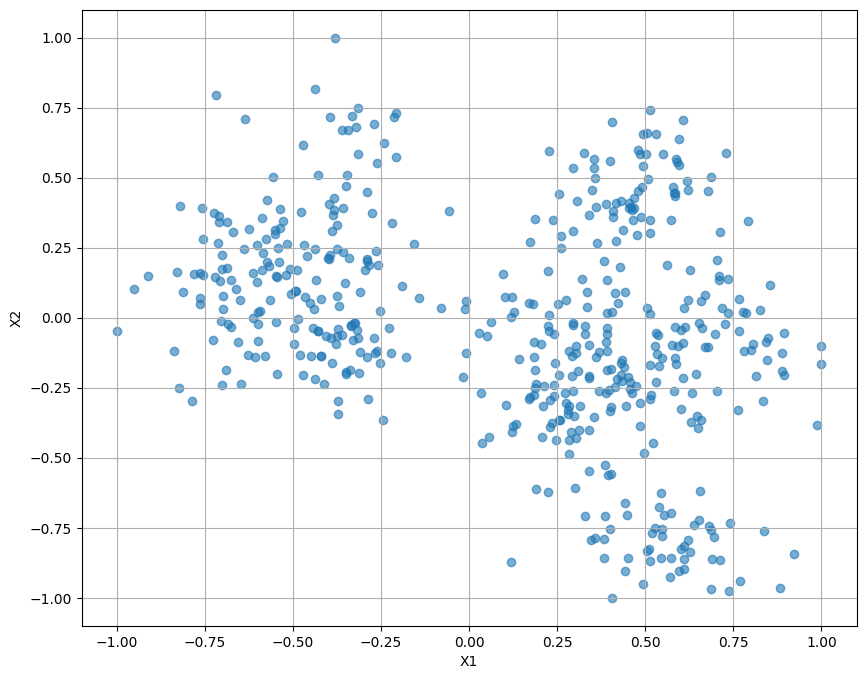

In [ ]:
# Plot the data
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], alpha=0.6)

plt.xlabel('X1')
plt.ylabel('X2')
plt.grid(True)
plt.show()

## VAE Architecture
In the following code blocks we will be implementing the VAE architecture. For this purpose we will first implement the individual components, the Encoder and Decoder networks, before combining them together and implementing the reparameterization trick.

### **Encoder**
The Encoder Network, $Q$, takes as input a single datasample and uses it to predict the mean and variance of the latent gaussian distribution over $z$. We are free in the choise of architecture for the encoder in general, but we do need to make sure that it has two output streams; one for the mean and one for the variance.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim):
        super(Encoder, self).__init__()

        modules = []
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Linear(input_dim, h_dim),
                    nn.ReLU(True)
                )
            )
            input_dim = h_dim  # Update the input dimension for the next layer

        self.encoder = nn.Sequential(*modules)
        self.mu = nn.Linear(hidden_dims[-1], latent_dim)  # Output layer for mean
        self.log_var = nn.Linear(hidden_dims[-1], latent_dim)  # Output layer for log variance

    def forward(self, x):
        hidden = self.encoder(x)
        return self.mu(hidden), self.log_var(hidden)


### Decoder
Similar to the encoder we are relatively free to implement the decoder using any appropriate architecture. Below we have chosen for a simple MLP with variable number of hidden layers. Note that we use a tanh layer to scale the inputs. This is also the reason why we have scaled the dataset to be between 0 and 1.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dims, output_dim):
        super(Decoder, self).__init__()

        modules = []
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Linear(latent_dim, h_dim),
                    nn.ReLU()
                )
            )
            latent_dim = h_dim  # Update the input dimension for the next layer

        # Add the output layer with tanh activation
        modules.append(nn.Linear(hidden_dims[-1], output_dim))
        modules.append(nn.Tanh())

        self.decoder = nn.Sequential(*modules)

    def forward(self, z):
        return self.decoder(z)

Lastly, we combine the encoder and the decoder into the VAE. We use the same architecture (in terms of the number of layers and nodes used) for both the encoder and decoder in this example, but this is not a requirement.

Observe that the forward function uses the reparameterization trick. This allows for low variance estimation of the gradient wrt the parameters of the encoder.

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim, output_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dims, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dims, output_dim)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        return self.decoder(z), mu, log_var

## Training Loop
With the VAE implemented we can start to train it using the ELBO as our loss. We have seen the ELBO a number of times during the lectures already, but once you look into the code of many VAE implementations you will find that the loss is often described in terms of a reconstruction loss and a KL-Divergence loss.

Fortunately, this is not different from the ELBO as we discussed it during the lectures. In the derivation below, starting from the ELBO, the terms in the last line are respectively refered to as the reconstruction loss and the KL-Divergence loss.

\begin{align}
  \log p(x) &\geq \sum_z q(z|x) (\log p(x,z) - \log q(z|x)) \\
            &\geq \sum_z q(z|x) (\log p(x|z) - \log p(z) - \log q(z|x)) \\
            &\geq \sum_z q(z|x) (\log p(x|z)) + \sum_z q(z|x)(\log q(z|x)
            - \log p(z)) \\
            &\geq \mathbb{E}_{q(z|x)}[\log p(x|z)] + \text{D}_{\text{KL}}[q(z|x)||p(z)]
\end{align}

A last note about the loss used is that you will find that we use the MSE-loss for the reconstruction loss, and scale the kld-loss with a $\beta$ parameter. We can interpret this as using a Gaussian $P(x|z)$ with ${\beta}$ as it's variance. This is relatively simple to proof if you want to give yourself a challenge.

In theory, the choice of $\beta$ is relatively important and we will focus on it later.



In [ ]:
# Hyperparameters
input_dim = 2
hidden_dims = [32, 64, 32]
latent_dim = 2
output_dim = 2
lr = 1e-3
epochs = 1000
beta = .03  # The beta hyperparameter for the KL divergence term

model = VAE(input_dim, hidden_dims, latent_dim, output_dim)
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
        optimizer.zero_grad()
        # Forward pass
        x_reconstructed, mu, log_var = model(X)

        # Reconstruction loss
        recon_loss = nn.functional.mse_loss(x_reconstructed, X, reduction='sum')

        # KL divergence loss
        kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Total loss with the beta trade-off
        loss = recon_loss + beta * kld_loss

        # Backward pass
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")


Epoch 0, Loss: 227.0828857421875
Epoch 100, Loss: 80.66561889648438
Epoch 200, Loss: 51.23659896850586
Epoch 300, Loss: 50.41564178466797
Epoch 400, Loss: 49.73816680908203
Epoch 500, Loss: 49.07451248168945
Epoch 600, Loss: 48.73841857910156
Epoch 700, Loss: 48.89427947998047
Epoch 800, Loss: 49.872406005859375
Epoch 900, Loss: 49.17768096923828


## Evaluation
Given the trained model, we can now evaluate how effectively it can be used to sample from our data distribution.

### Reconstructed data
The plot below show the original data and the reconstructed data. You can also observe here how the beta parameter is used to scale the Gaussian used in the last step of the reconstruction.

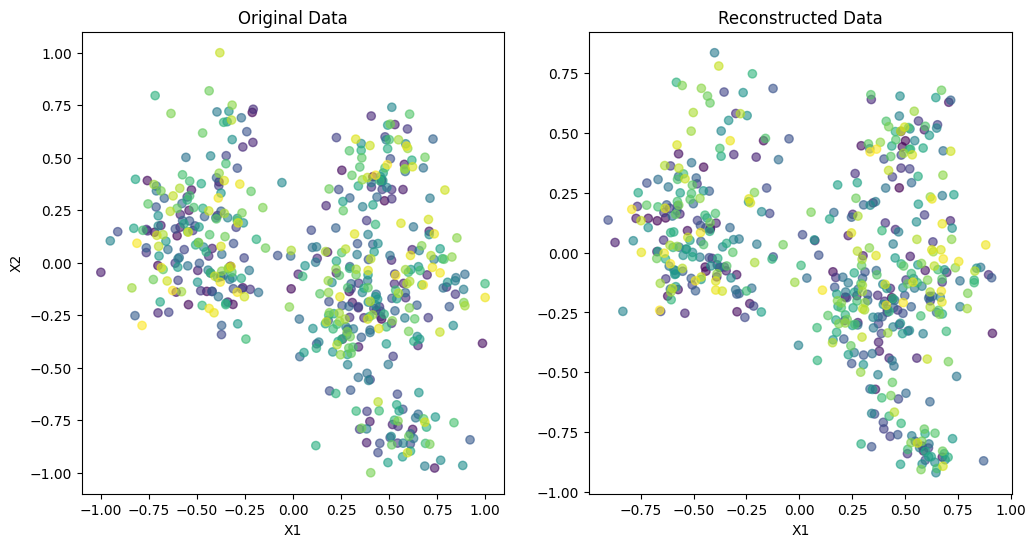

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_vae_with_colors(X, model):
    model.eval()

    with torch.no_grad():
        # Reconstruct data through the VAE
        X_reconstructed, _, _ = model(X)
        X_reconstructed_np = X_reconstructed.detach().numpy()

    # Here, we sample from a normal distribution around the means
    X_reconstructed_sampled = np.random.normal(loc=X_reconstructed_np, scale=beta)

    # Generate a color map based on the index of each data point
    colors = plt.cm.viridis(np.linspace(0, 1, len(X)))

    # Plot original data
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], color=colors, alpha=0.6)
    plt.title('Original Data')
    plt.xlabel('X1')
    plt.ylabel('X2')

    # Plot reconstructed data
    plt.subplot(1, 2, 2)
    plt.scatter(X_reconstructed_sampled[:, 0], X_reconstructed_sampled[:, 1], color=colors, alpha=0.6)
    plt.title('Reconstructed Data')
    plt.xlabel('X1')

    plt.show()

plot_vae_with_colors(X, model)


### Latent representation
For a VAE to be effective in generating new samples it is important that the original datasamples are fully encoded to a Gaussian latent representation. If this is not the case there might be areas in the latent representation that we would like to sample from that have not been sufficiently learned to decode.

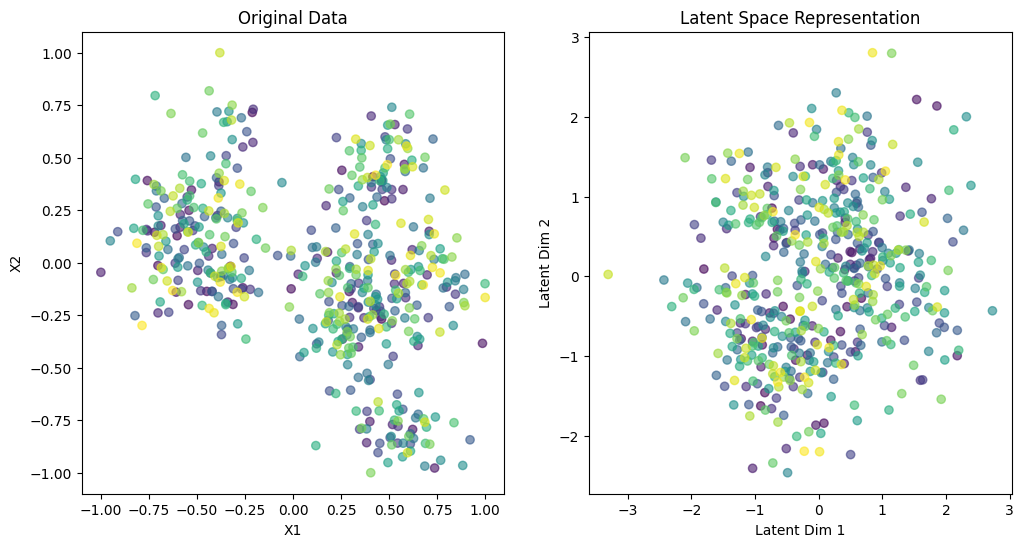

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_data_and_latent_space(X, model):
    model.eval()

    with torch.no_grad():
        # Encode data to get the mean and log variance of the latent space distribution
        mu, log_var = model.encoder(X)
        std = torch.exp(0.5 * log_var)

        # Sample from the distribution using the reparameterization trick
        eps = torch.randn_like(std)
        z = mu + eps * std  # Reparameterized sample

        sampled_z_np = z.detach().numpy()

    # Generate a color map based on the index of each data point
    colors = plt.cm.viridis(np.linspace(0, 1, len(X)))

    # Plot original data
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], color=colors, alpha=0.6)
    plt.title('Original Data')
    plt.xlabel('X1')
    plt.ylabel('X2')

    # Plot latent space representation
    plt.subplot(1, 2, 2)
    plt.scatter(sampled_z_np[:, 0], sampled_z_np[:, 1], color=colors, alpha=0.6)
    plt.title('Latent Space Representation')
    plt.xlabel('Latent Dim 1')
    plt.ylabel('Latent Dim 2')

    plt.show()

plot_data_and_latent_space(X, model)


### Generating new samples
Now that we are relatively sure that the encoded latent space is a Gaussian, we can simply generate new data samples by sampling from the data distribution and consequtively decoding this sample.

<ipython-input-12-fd668ef133f2>:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap))
<ipython-input-12-fd668ef133f2>:38: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap))


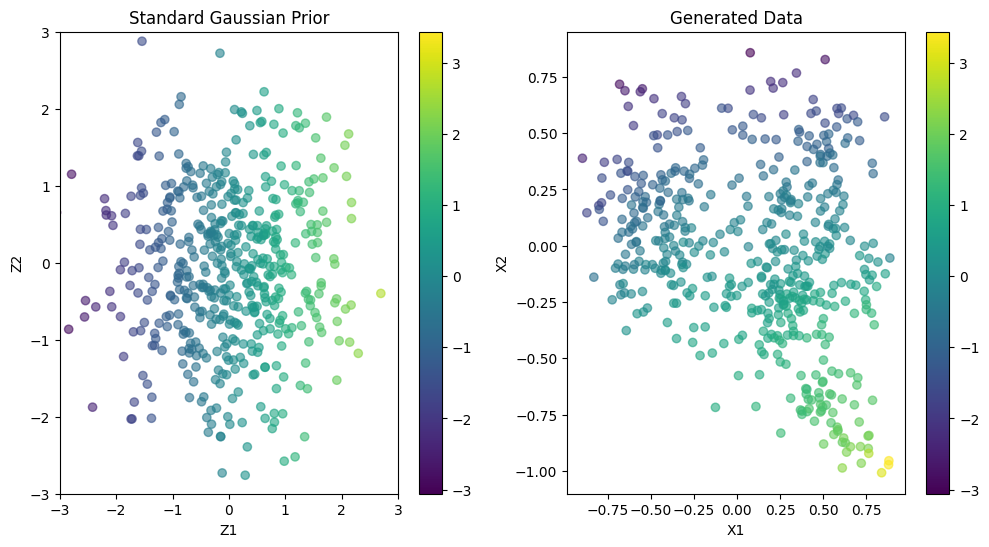

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_prior_and_generated_data_mapped_gradient(model, num_samples=500):
    model.eval()

    with torch.no_grad():
        # Sample from the prior (standard normal distribution in the latent space)
        z_samples = torch.randn(num_samples, latent_dim)

        # Decode the samples to generate data
        generated_means = model.decoder(z_samples).cpu().numpy()
        generated_data = np.random.normal(loc=generated_means, scale=beta)

    # Use the first dimension of z_samples for coloring both plots
    z_colors = z_samples[:, 0].numpy()

    # Create a colormap based on the first dimension of the latent samples
    norm = plt.Normalize(vmin=min(z_colors), vmax=max(z_colors))
    cmap = plt.get_cmap('viridis')
    colors = cmap(norm(z_colors))

    # Plot the standard Gaussian prior with a gradient color based on the first dimension
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(z_samples[:, 0], z_samples[:, 1], color=colors, alpha=0.6)
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap))
    plt.title('Standard Gaussian Prior')
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])
    plt.xlabel('Z1')
    plt.ylabel('Z2')

    # Plot the generated data points with the same gradient color
    plt.subplot(1, 2, 2)
    plt.scatter(generated_data[:, 0], generated_data[:, 1], color=colors, alpha=0.6)
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap))
    plt.title('Generated Data')
    plt.xlabel('X1')
    plt.ylabel('X2')

    plt.show()

plot_prior_and_generated_data_mapped_gradient(model)


### Likelihood
Lastly, we plot the likelihood of our model below. Note that VAE's do not provide a exact likelihood method. Instead we approximate it below using MC.

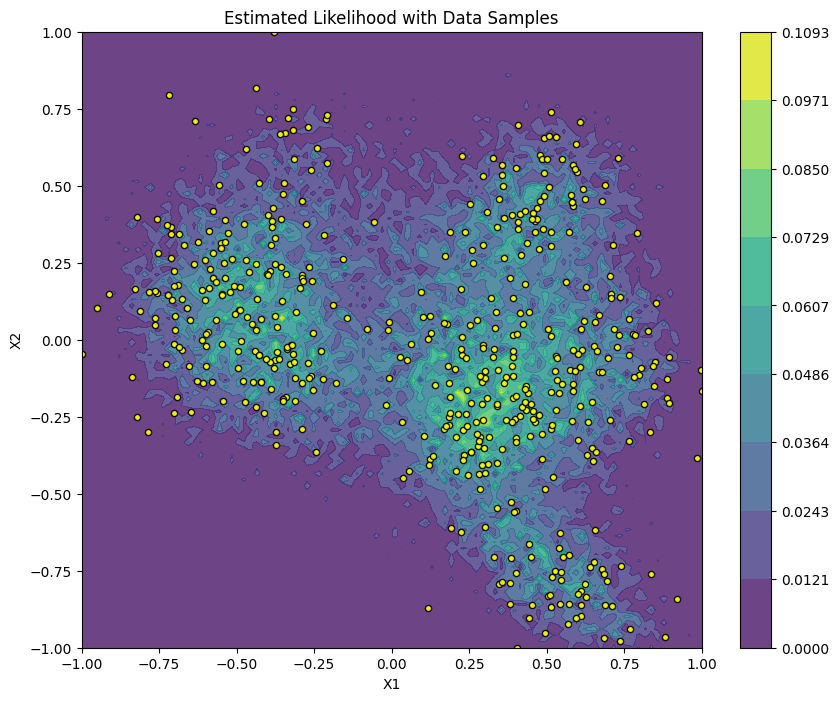

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def visualize_likelihood_on_grid_with_data_samples(decoder, X, latent_dim, grid_width=1, grid_height=1, grid_resolution=100, std_dev=0.1):
    # Define the grid over the data space
    x = np.linspace(-grid_width, grid_width, grid_resolution)
    y = np.linspace(-grid_height, grid_height, grid_resolution)
    X_grid, Y_grid = np.meshgrid(x, y)
    grid_shape = X_grid.shape

    # Flatten the grid for batch processing
    grid_points = np.vstack((X_grid.ravel(), Y_grid.ravel())).T

    # Convert to a PyTorch tensor
    grid_points_tensor = torch.from_numpy(grid_points).float()

    # Perform Monte Carlo approximation of the likelihood on the grid
    likelihoods = np.zeros(grid_points.shape[0])

    # Number of Monte Carlo samples
    num_samples = 100
    for _ in range(num_samples):
        # Sample z from the prior (standard normal)
        z_samples = torch.randn(len(grid_points), latent_dim)

        # Decode z to get x (mean of p(x|z))
        with torch.no_grad():
            x_samples = decoder(z_samples).cpu().numpy()

        # Compute the likelihood of the grid points under the Gaussian
        # Assume a Gaussian likelihood with a mean given by the decoder's output and some fixed std_dev
        for i, point in enumerate(grid_points):
            likelihoods[i] += np.exp(-0.5 * np.sum((point - x_samples[i])**2 / std_dev**2))

    # Average the likelihoods over the number of samples
    likelihoods /= num_samples

    # Reshape the likelihoods to the shape of the grid
    likelihoods = likelihoods.reshape(grid_shape)

    # Plot the likelihoods
    plt.figure(figsize=(10, 8))
    contour_levels = np.linspace(likelihoods.min(), likelihoods.max(), num=10)
    contour = plt.contourf(X_grid, Y_grid, likelihoods, levels=contour_levels, cmap='viridis', alpha=0.8)
    plt.colorbar(contour)

    # Normalize the original data points for coloring
    norm = plt.Normalize(X[:, 0].min(), X[:, 0].max())

    # Overlay the data samples on the likelihood plot
    plt.scatter(X[:, 0], X[:, 1], color='yellow', edgecolor='k', s=20, alpha=0.9)

    plt.title('Estimated Likelihood with Data Samples')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()

visualize_likelihood_on_grid_with_data_samples(model.decoder, X, latent_dim=2)



As highlighted, the beta parameter can play an interesting role in the tradeoff between the reconstruction and the KL part of the loss. In this part we are going to investigate what the impact of it is exactly.

**TASK:**
- Try different values for beta and explain what you observe. Try at least 10, 1, 0.1, 0.01, and 0.001.
- Argue which value is the best.
- Plot the value of the reconstruction loss and KL-loss for various values of beta. Can you observe an optimal value here?

In [ ]:
# Hyperparameters
input_dim = 2
hidden_dims = [32, 64, 32]
latent_dim = 2
output_dim = 2
lr = 1e-3
epochs = 1000
beta_values = [10, 1, 0.1, 0.01, 0.001]  # The beta hyperparameter for the KL divergence term

for beta in tqdm(beta_values):
    model = VAE(input_dim, hidden_dims, latent_dim, output_dim)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        optimizer.zero_grad()
        # Forward pass
        x_reconstructed, mu, log_var = model(X)

        # Reconstruction loss
        recon_loss = nn.functional.mse_loss(x_reconstructed, X, reduction='sum')

        # KL divergence loss
        kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Total loss with the beta trade-off
        loss = recon_loss + beta * kld_loss

        # Backward pass
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}, Beta: {beta}")


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0, Loss: 401.29827880859375, Beta: 10
Epoch 100, Loss: 199.9674530029297, Beta: 10
Epoch 200, Loss: 198.67453002929688, Beta: 10
Epoch 300, Loss: 199.5787353515625, Beta: 10
Epoch 400, Loss: 199.4077606201172, Beta: 10
Epoch 500, Loss: 199.0853729248047, Beta: 10
Epoch 600, Loss: 199.4415283203125, Beta: 10
Epoch 700, Loss: 199.1931915283203, Beta: 10
Epoch 800, Loss: 199.3070068359375, Beta: 10
Epoch 900, Loss: 198.9949951171875, Beta: 10


 20%|██        | 1/5 [00:04<00:17,  4.44s/it]

Epoch 0, Loss: 209.63211059570312, Beta: 1
Epoch 100, Loss: 199.46791076660156, Beta: 1
Epoch 200, Loss: 199.2525634765625, Beta: 1
Epoch 300, Loss: 199.4980926513672, Beta: 1
Epoch 400, Loss: 199.6765899658203, Beta: 1
Epoch 500, Loss: 199.93350219726562, Beta: 1
Epoch 600, Loss: 199.1488037109375, Beta: 1
Epoch 700, Loss: 199.3126678466797, Beta: 1
Epoch 800, Loss: 199.47439575195312, Beta: 1
Epoch 900, Loss: 199.1431884765625, Beta: 1


 40%|████      | 2/5 [00:09<00:14,  4.83s/it]

Epoch 0, Loss: 223.3213653564453, Beta: 0.1
Epoch 100, Loss: 127.87818908691406, Beta: 0.1
Epoch 200, Loss: 108.82453918457031, Beta: 0.1
Epoch 300, Loss: 106.91044616699219, Beta: 0.1
Epoch 400, Loss: 104.41880798339844, Beta: 0.1
Epoch 500, Loss: 108.96231842041016, Beta: 0.1
Epoch 600, Loss: 108.74144744873047, Beta: 0.1
Epoch 700, Loss: 104.60914611816406, Beta: 0.1
Epoch 800, Loss: 108.52487182617188, Beta: 0.1
Epoch 900, Loss: 105.82597351074219, Beta: 0.1


 60%|██████    | 3/5 [00:14<00:09,  4.81s/it]

Epoch 0, Loss: 257.2203674316406, Beta: 0.01
Epoch 100, Loss: 64.4256591796875, Beta: 0.01
Epoch 200, Loss: 45.108341217041016, Beta: 0.01
Epoch 300, Loss: 27.424549102783203, Beta: 0.01
Epoch 400, Loss: 22.852767944335938, Beta: 0.01
Epoch 500, Loss: 22.072429656982422, Beta: 0.01
Epoch 600, Loss: 22.13353157043457, Beta: 0.01
Epoch 700, Loss: 21.847824096679688, Beta: 0.01
Epoch 800, Loss: 22.17024803161621, Beta: 0.01
Epoch 900, Loss: 21.675621032714844, Beta: 0.01


 80%|████████  | 4/5 [00:18<00:04,  4.67s/it]

Epoch 0, Loss: 226.27212524414062, Beta: 0.001
Epoch 100, Loss: 27.739341735839844, Beta: 0.001
Epoch 200, Loss: 5.119415760040283, Beta: 0.001
Epoch 300, Loss: 4.256392478942871, Beta: 0.001
Epoch 400, Loss: 3.936732292175293, Beta: 0.001
Epoch 500, Loss: 3.7041938304901123, Beta: 0.001
Epoch 600, Loss: 3.661642551422119, Beta: 0.001
Epoch 700, Loss: 3.618828058242798, Beta: 0.001
Epoch 800, Loss: 3.569023847579956, Beta: 0.001
Epoch 900, Loss: 3.4833457469940186, Beta: 0.001


100%|██████████| 5/5 [00:24<00:00,  4.82s/it]


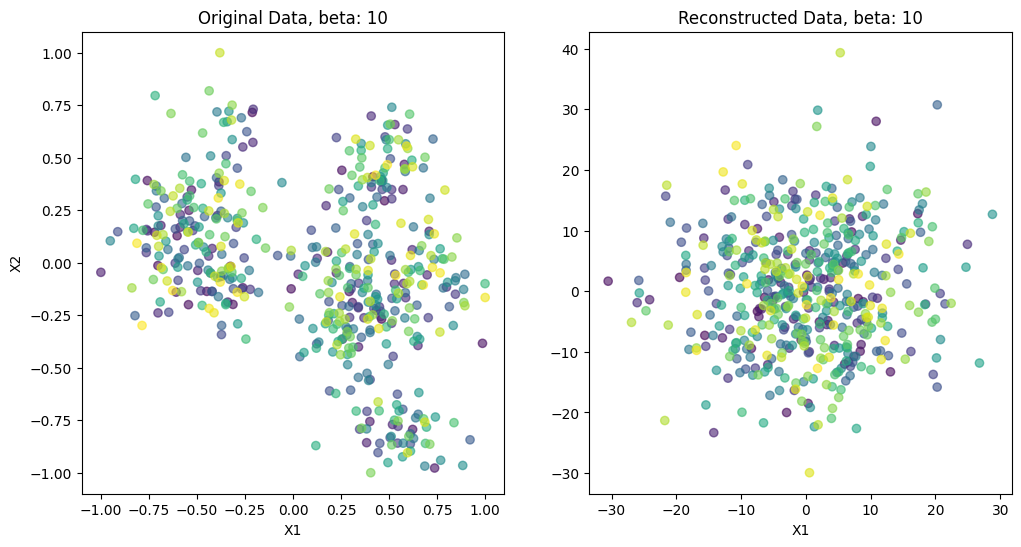

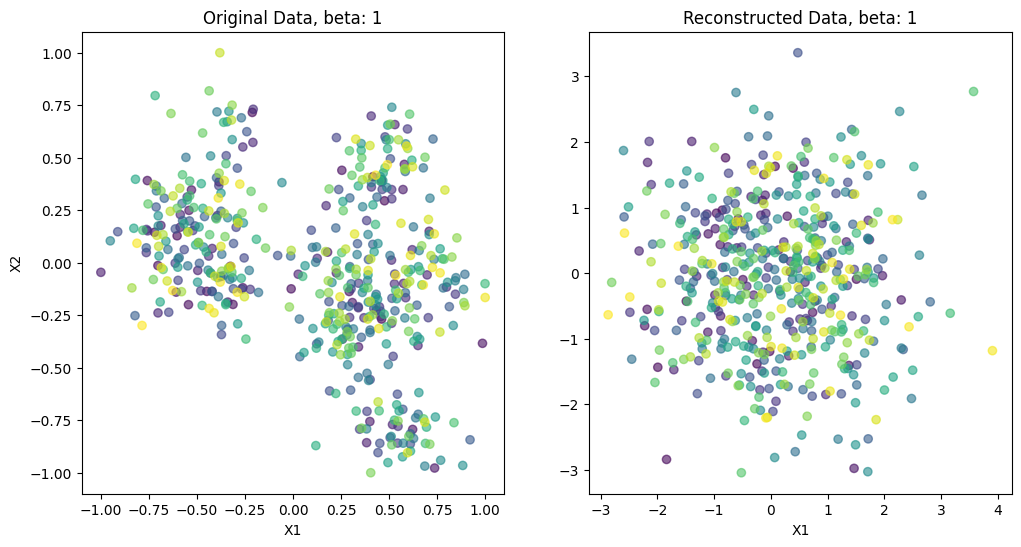

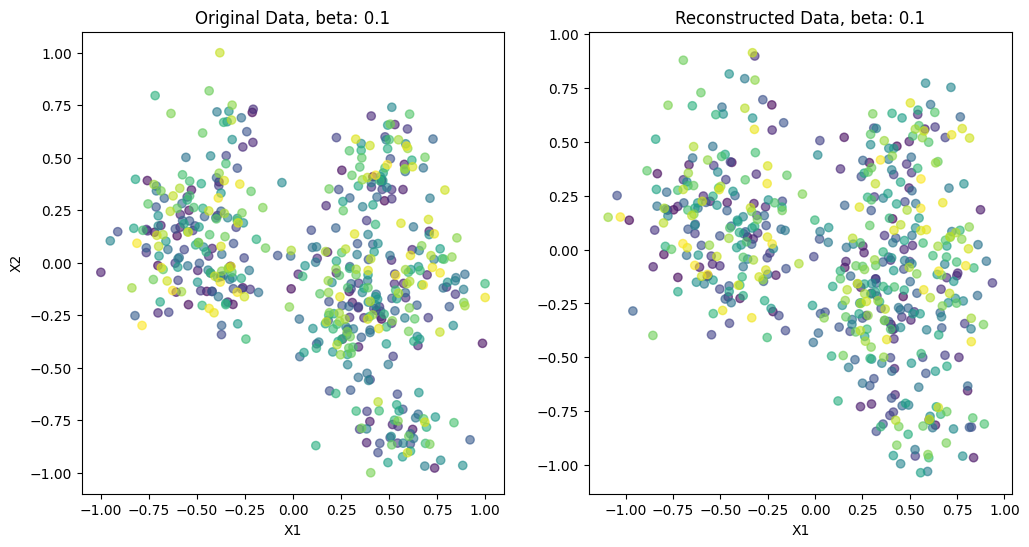

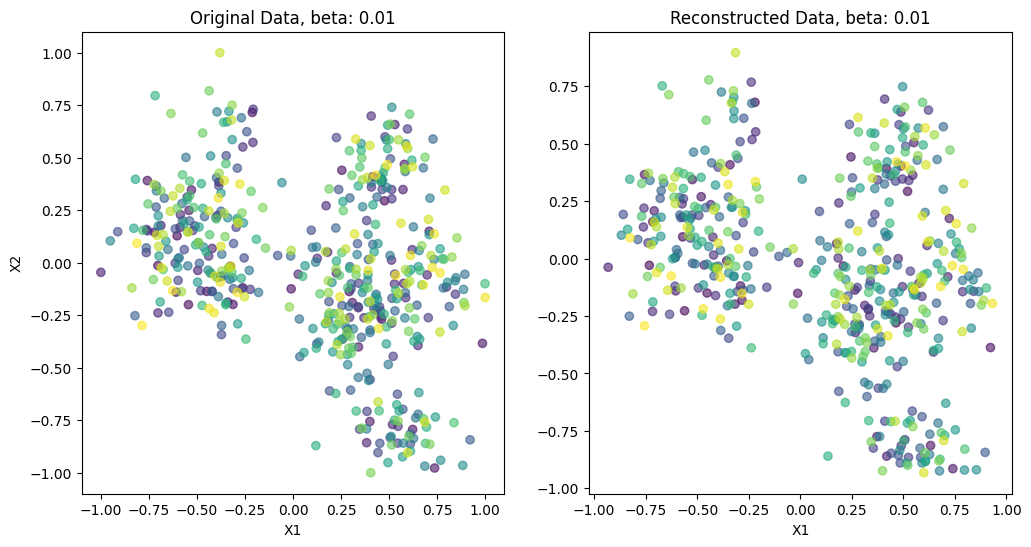

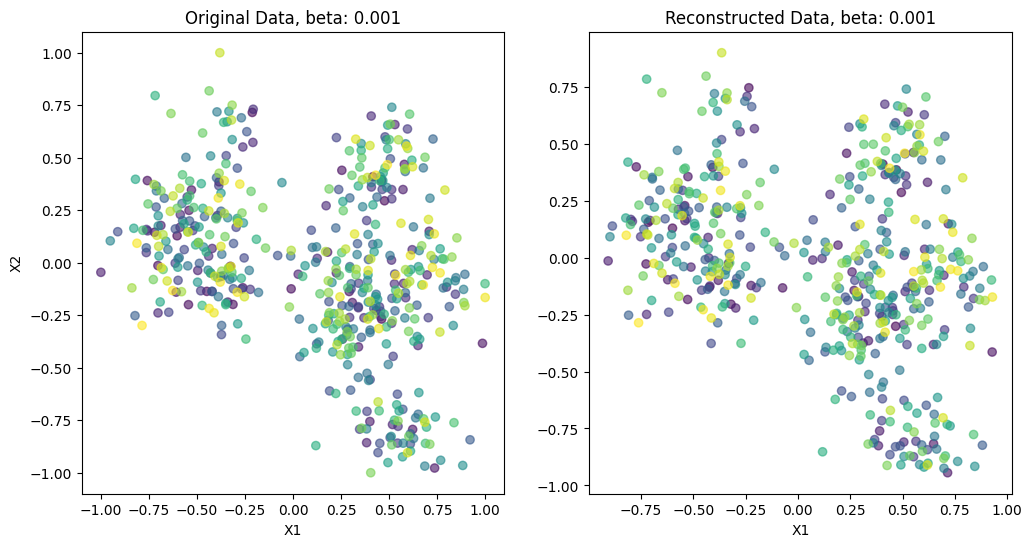

In [ ]:
def plot_vae_with_colors(X, model, beta):
    model.eval()

    with torch.no_grad():
        # Reconstruct data through the VAE
        X_reconstructed, _, _ = model(X)
        X_reconstructed_np = X_reconstructed.detach().numpy()

    # Here, we sample from a normal distribution around the means
    X_reconstructed_sampled = np.random.normal(loc=X_reconstructed_np, scale=beta)

    # Generate a color map based on the index of each data point
    colors = plt.cm.viridis(np.linspace(0, 1, len(X)))

    # Plot original data
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], color=colors, alpha=0.6)
    plt.title(f'Original Data, beta: {beta}')
    plt.xlabel('X1')
    plt.ylabel('X2')

    # Plot reconstructed data
    plt.subplot(1, 2, 2)
    plt.scatter(X_reconstructed_sampled[:, 0], X_reconstructed_sampled[:, 1], color=colors, alpha=0.6)
    plt.title(f'Reconstructed Data, beta: {beta}')
    plt.xlabel('X1')

    plt.show()

for beta in beta_values:
  plot_vae_with_colors(X, model, beta)


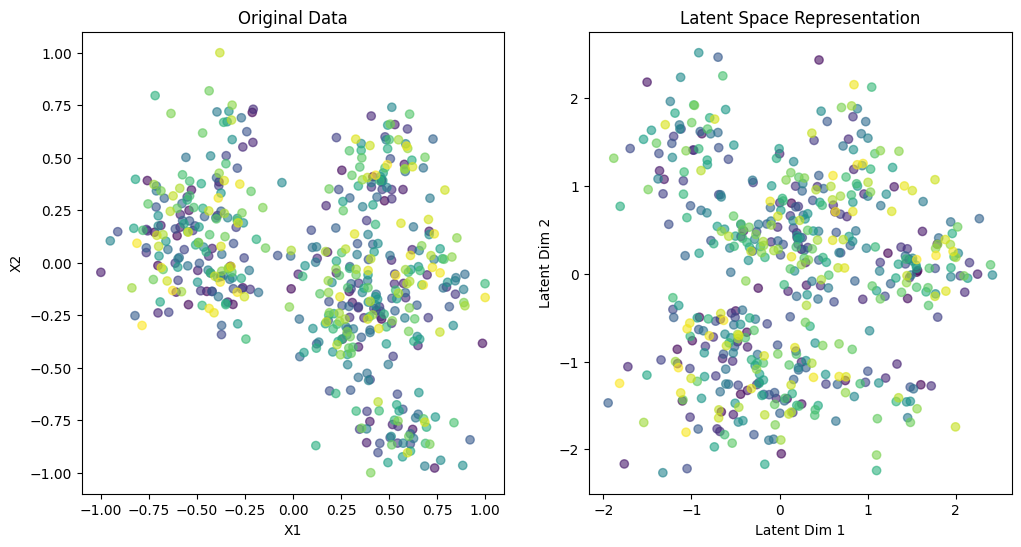

In [ ]:
def plot_data_and_latent_space(X, model):
    model.eval()

    with torch.no_grad():
        # Encode data to get the mean and log variance of the latent space distribution
        mu, log_var = model.encoder(X)
        std = torch.exp(0.5 * log_var)

        # Sample from the distribution using the reparameterization trick
        eps = torch.randn_like(std)
        z = mu + eps * std  # Reparameterized sample

        sampled_z_np = z.detach().numpy()

    # Generate a color map based on the index of each data point
    colors = plt.cm.viridis(np.linspace(0, 1, len(X)))

    # Plot original data
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], color=colors, alpha=0.6)
    plt.title('Original Data')
    plt.xlabel('X1')
    plt.ylabel('X2')

    # Plot latent space representation
    plt.subplot(1, 2, 2)
    plt.scatter(sampled_z_np[:, 0], sampled_z_np[:, 1], color=colors, alpha=0.6)
    plt.title('Latent Space Representation')
    plt.xlabel('Latent Dim 1')
    plt.ylabel('Latent Dim 2')

    plt.show()

plot_data_and_latent_space(X, model)


<ipython-input-17-f883375464fe>:24: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap))
<ipython-input-17-f883375464fe>:34: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap))


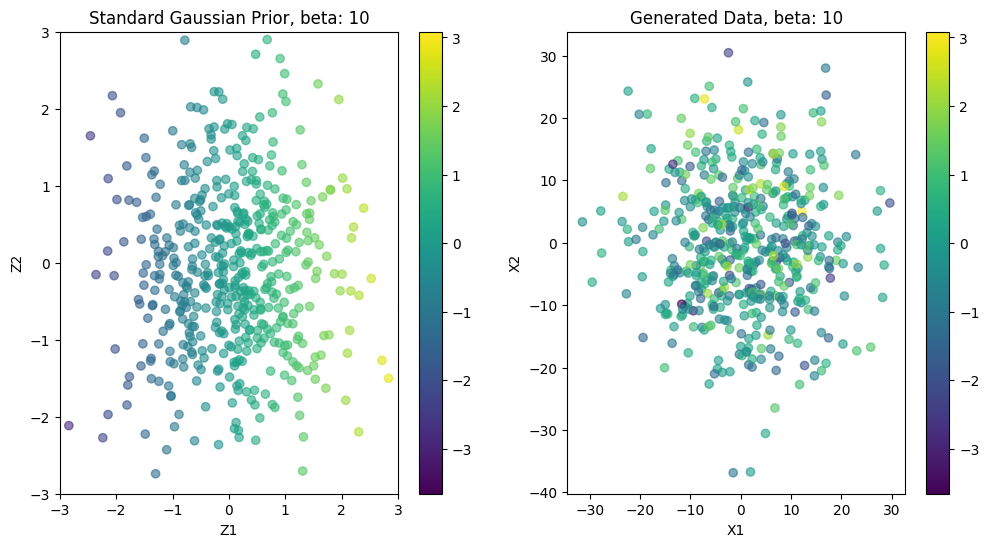

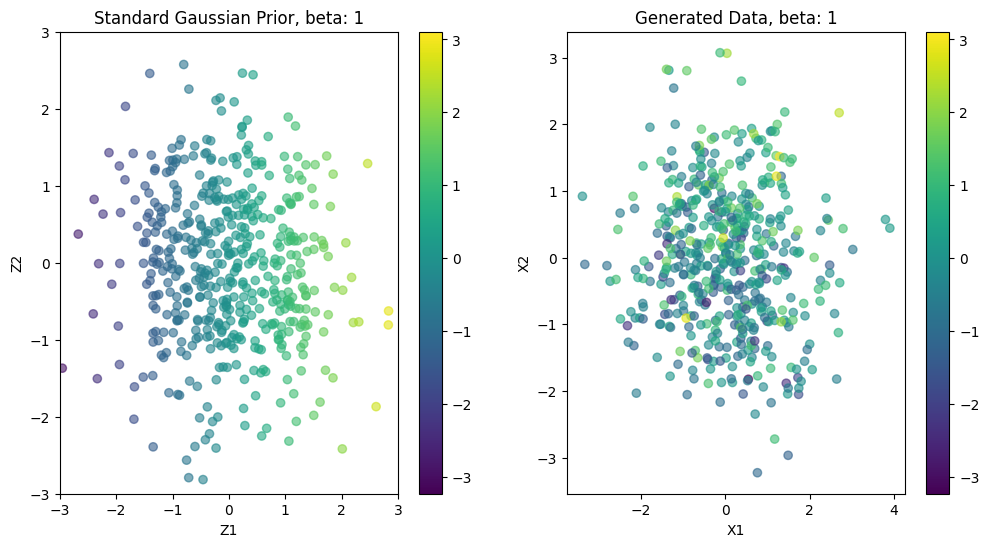

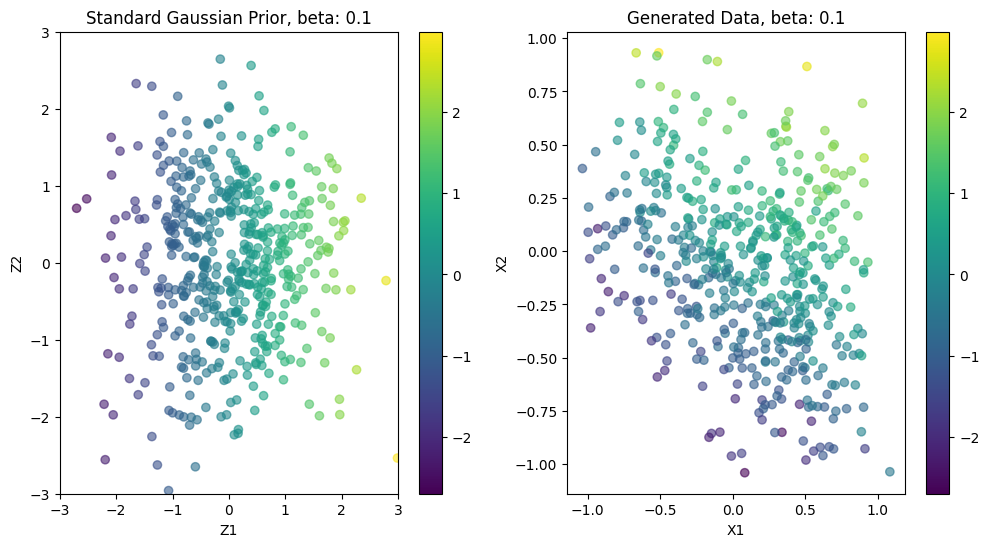

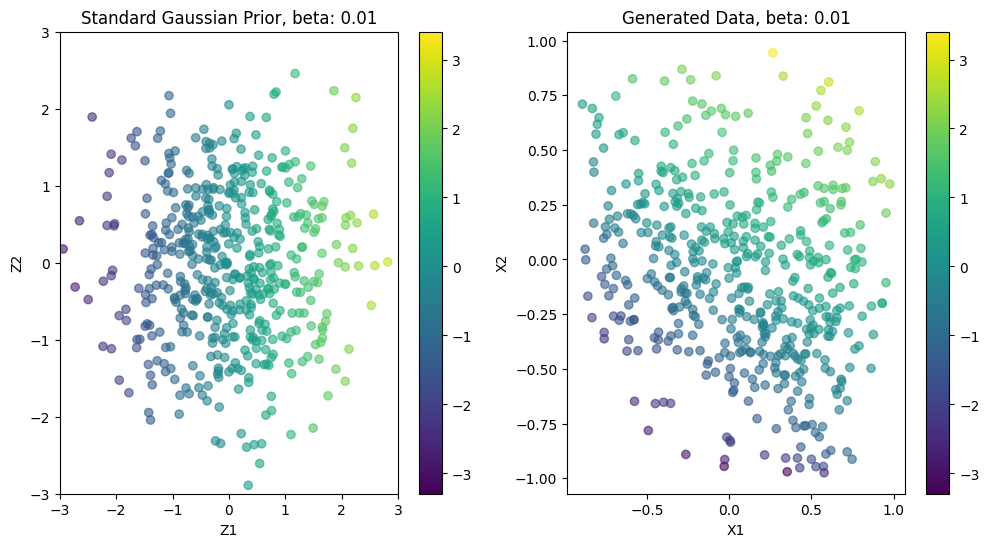

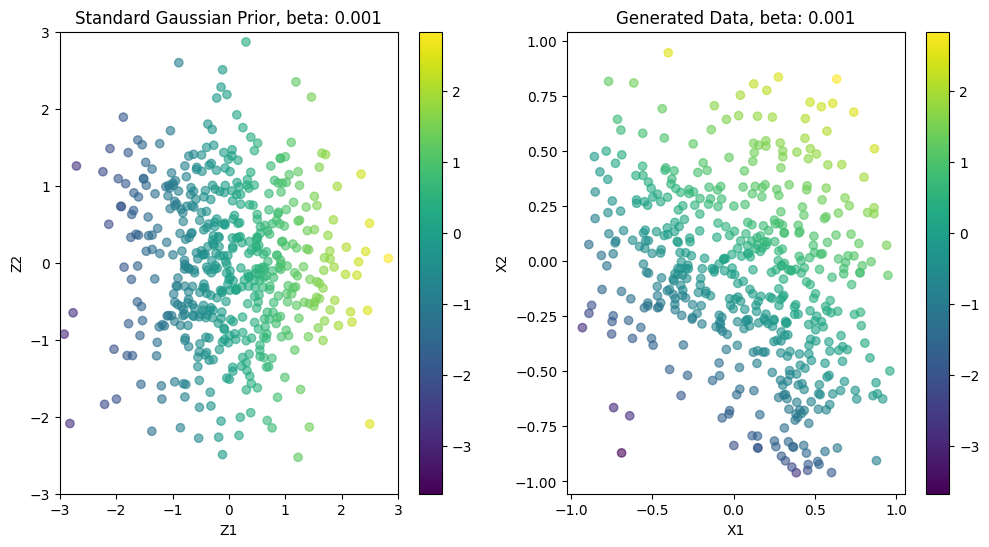

In [ ]:
def plot_prior_and_generated_data_mapped_gradient(model, beta, num_samples=500):
    model.eval()

    with torch.no_grad():
        # Sample from the prior (standard normal distribution in the latent space)
        z_samples = torch.randn(num_samples, latent_dim)

        # Decode the samples to generate data
        generated_means = model.decoder(z_samples).cpu().numpy()
        generated_data = np.random.normal(loc=generated_means, scale=beta)

    # Use the first dimension of z_samples for coloring both plots
    z_colors = z_samples[:, 0].numpy()

    # Create a colormap based on the first dimension of the latent samples
    norm = plt.Normalize(vmin=min(z_colors), vmax=max(z_colors))
    cmap = plt.get_cmap('viridis')
    colors = cmap(norm(z_colors))

    # Plot the standard Gaussian prior with a gradient color based on the first dimension
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(z_samples[:, 0], z_samples[:, 1], color=colors, alpha=0.6)
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap))
    plt.title(f'Standard Gaussian Prior, beta: {beta}')
    plt.xlim([-3, 3])
    plt.ylim([-3, 3])
    plt.xlabel('Z1')
    plt.ylabel('Z2')

    # Plot the generated data points with the same gradient color
    plt.subplot(1, 2, 2)
    plt.scatter(generated_data[:, 0], generated_data[:, 1], color=colors, alpha=0.6)
    plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap))
    plt.title(f'Generated Data, beta: {beta}')
    plt.xlabel('X1')
    plt.ylabel('X2')

    plt.show()

for beta in beta_values:
  plot_prior_and_generated_data_mapped_gradient(model,beta)

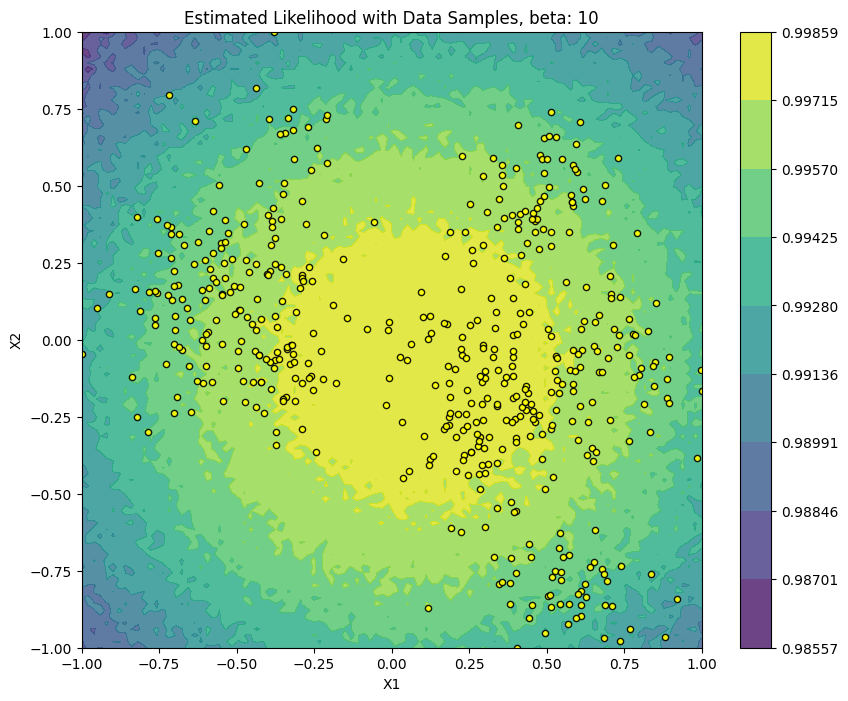

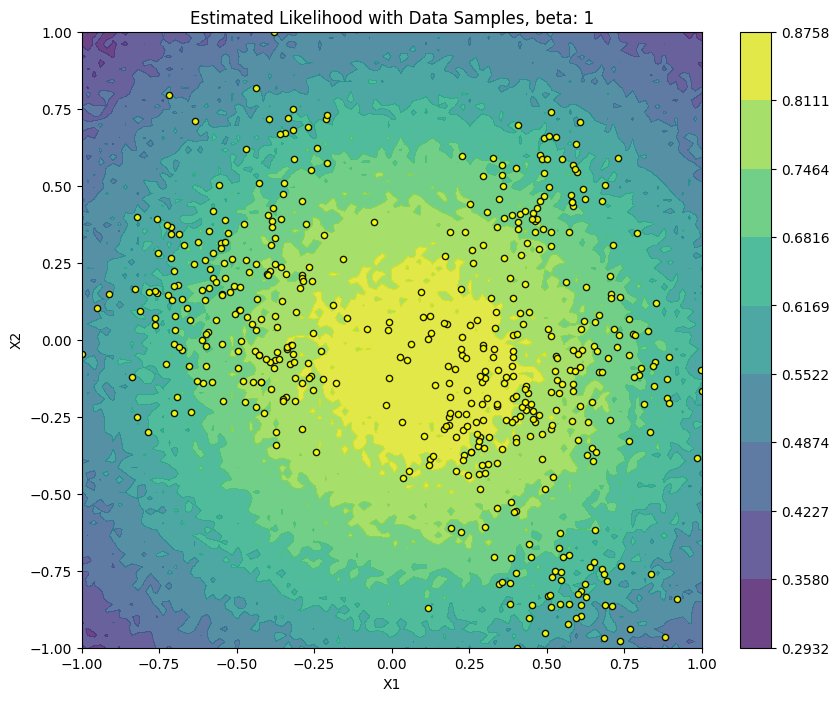

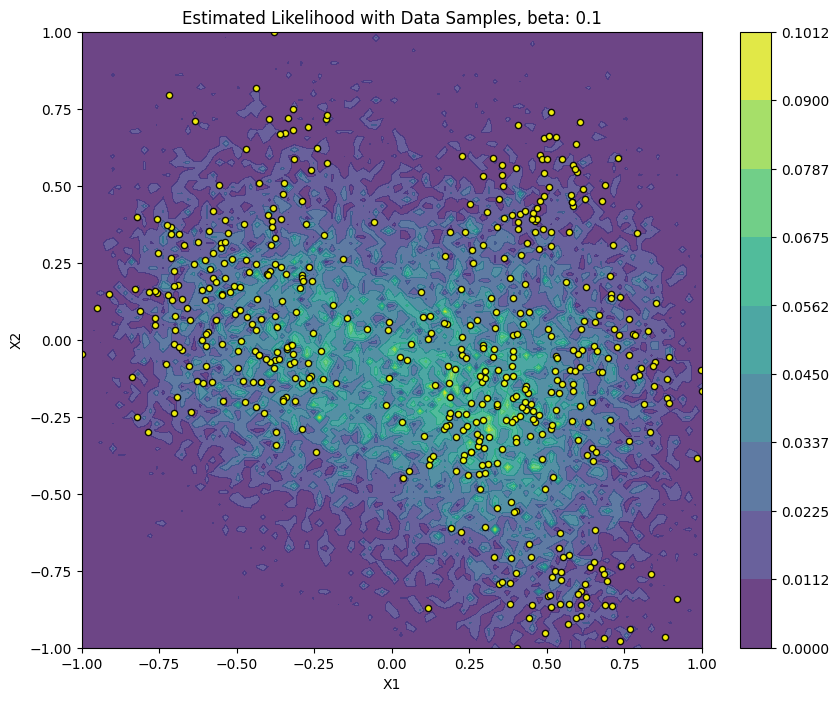

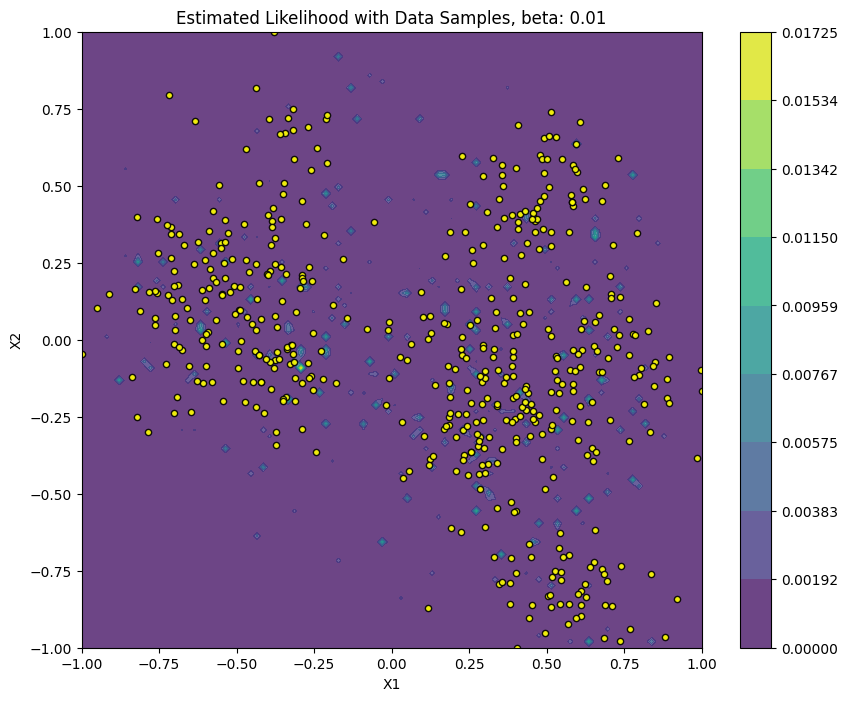

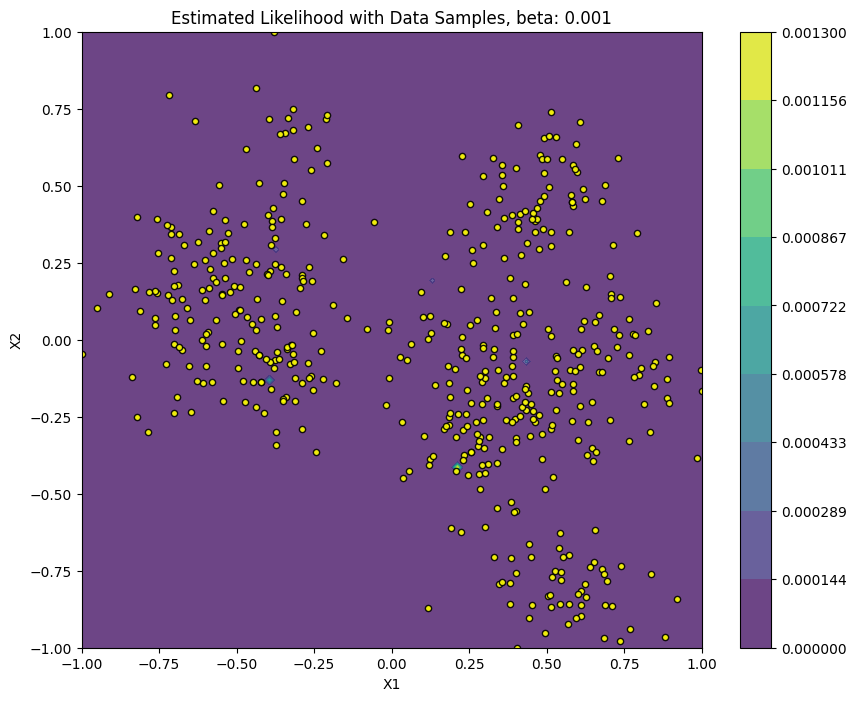

In [ ]:
def visualize_likelihood_on_grid_with_data_samples(decoder, X, latent_dim, beta, grid_width=1, grid_height=1, grid_resolution=100, std_dev=0.1):
    # Define the grid over the data space
    x = np.linspace(-grid_width, grid_width, grid_resolution)
    y = np.linspace(-grid_height, grid_height, grid_resolution)
    X_grid, Y_grid = np.meshgrid(x, y)
    grid_shape = X_grid.shape

    # Flatten the grid for batch processing
    grid_points = np.vstack((X_grid.ravel(), Y_grid.ravel())).T

    # Convert to a PyTorch tensor
    grid_points_tensor = torch.from_numpy(grid_points).float()

    # Perform Monte Carlo approximation of the likelihood on the grid
    likelihoods = np.zeros(grid_points.shape[0])

    # Number of Monte Carlo samples
    num_samples = 100
    for _ in range(num_samples):
        # Sample z from the prior (standard normal)
        z_samples = torch.randn(len(grid_points), latent_dim)

        # Decode z to get x (mean of p(x|z))
        with torch.no_grad():
            x_samples = decoder(z_samples).cpu().numpy()

        # Compute the likelihood of the grid points under the Gaussian
        # Assume a Gaussian likelihood with a mean given by the decoder's output and some fixed std_dev
        for i, point in enumerate(grid_points):
            likelihoods[i] += np.exp(-0.5 * np.sum((point - x_samples[i])**2 / beta**2))

    # Average the likelihoods over the number of samples
    likelihoods /= num_samples

    # Reshape the likelihoods to the shape of the grid
    likelihoods = likelihoods.reshape(grid_shape)

    # Plot the likelihoods
    plt.figure(figsize=(10, 8))
    contour_levels = np.linspace(likelihoods.min(), likelihoods.max(), num=10)
    contour = plt.contourf(X_grid, Y_grid, likelihoods, levels=contour_levels, cmap='viridis', alpha=0.8)
    plt.colorbar(contour)

    # Normalize the original data points for coloring
    norm = plt.Normalize(X[:, 0].min(), X[:, 0].max())

    # Overlay the data samples on the likelihood plot
    plt.scatter(X[:, 0], X[:, 1], color='yellow', edgecolor='k', s=20, alpha=0.9)

    plt.title(f'Estimated Likelihood with Data Samples, beta: {beta}')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()


for beta in beta_values:
  visualize_likelihood_on_grid_with_data_samples(model.decoder, X, latent_dim=2, beta=beta)


*ANSWER:* <br>
As beta decreases, the loss deceases. beta = 0.001 gives the lowest lost. It means that the reconstructed data is very close to the original data.